# Sentiment Analysis on Movie reviews taken from IMDB dataset

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

## Loading Data

In [5]:
df = pd.read_csv('IMDB Dataset.csv')

print("Shape of the data:", df.shape)
df.head()

Shape of the data: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### dataset analysis

In [6]:
df.describe

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

### word count

Average Review Length: 231.15694


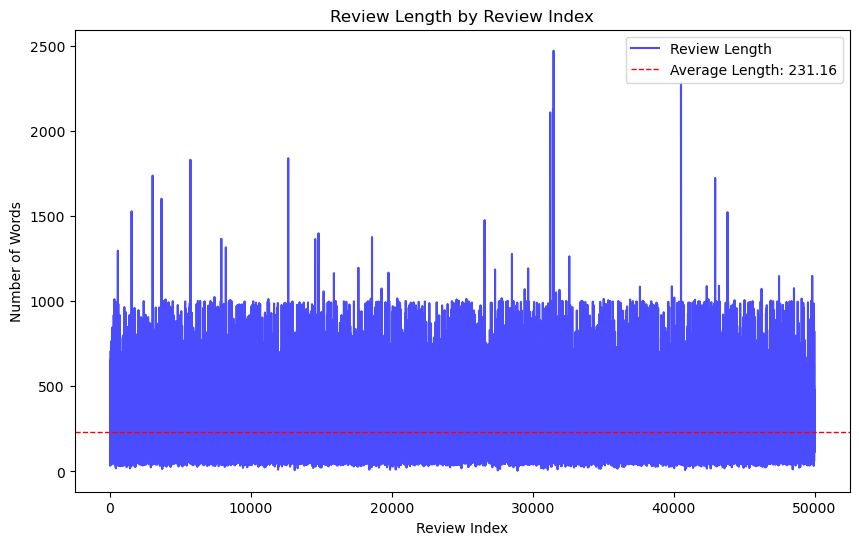

In [7]:
# Calculate length of each review
df['original_word_count'] = df['review'].apply(lambda x: len(x.split()))
average_review_length = df['original_word_count'].mean()
print(f"Average Review Length: {average_review_length}")

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['original_word_count'], color='blue', alpha=0.7, label='Review Length')
plt.axhline(average_review_length, color='red', linestyle='dashed', linewidth=1, label=f'Average Length: {average_review_length:.2f}')
plt.title('Review Length by Review Index')
plt.xlabel('Review Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

#### The quality of the reviews is pretty good with a good amount of words to analyze. Since the number of words is also huge, it first needs to be reduced into simplified versions and then fed into the model.

#### Distribution of sentiments

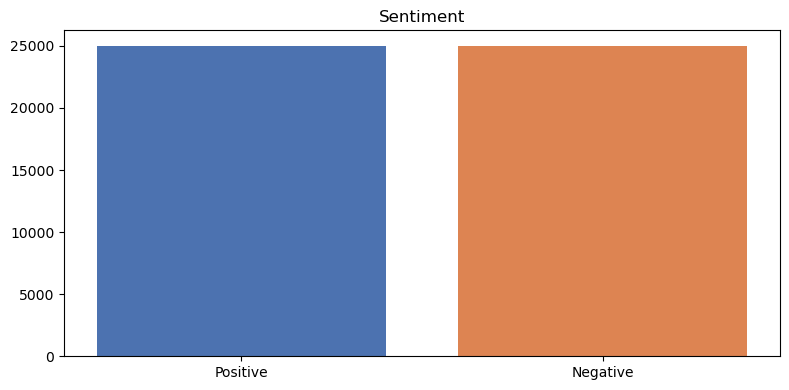

In [8]:
df_positive = df[df['sentiment']=='positive']
df_negative = df[df['sentiment']=='negative']

df_review_imb = pd.concat([df_positive,df_negative ])
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

#### the sentiments are equally balanced and are good samples to analyse and learn patterns on.

### Word count wrt to sentiments

In [9]:
average_review_length = df['original_word_count'].mean()
print(f"Average Review Length: {average_review_length}")

Average Review Length: 231.15694


/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/akshathaaavina

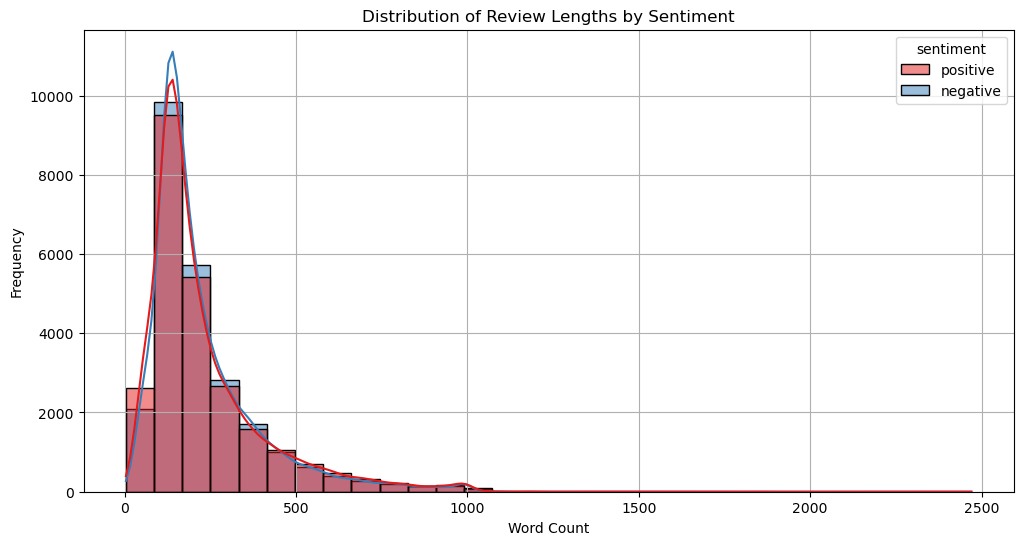

In [10]:
df['original_word_count'] = df['review'].apply(lambda x: len(x.split()))
# Plot the distribution of word counts by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='original_word_count', hue='sentiment', kde=True, bins=30, palette='Set1')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### width of graph is less = low variability in review lengths = balanced data set
#### bar graphs overlap with neglible differences = same review lengths for both sentiments

## Text preprocessing

In [11]:
# processes review and returns a list of words
def review_to_words(review, string = True, remove_stopwords=True):
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # lower case and split them
    words = review_text.lower().split()
    # stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    if string:
        return " ".join(words)
    else:
        return words

In [12]:
df['cleaned_reviews'] = df['review'].apply(review_to_words)

/var/folders/l6/dq5vy0f15j5gm000kg0cjppm0000gn/T/ipykernel_61434/3212001676.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review).get_text()


In [13]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)
# all the sentiment label is converted to 1s and 0s. positive = 1, negative = 0

/var/folders/l6/dq5vy0f15j5gm000kg0cjppm0000gn/T/ipykernel_61434/2518194905.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [14]:
print(df)

                                                  review  sentiment  \
0      One of the other reviewers has mentioned that ...          1   
1      A wonderful little production. <br /><br />The...          1   
2      I thought this was a wonderful way to spend ti...          1   
3      Basically there's a family where a little boy ...          0   
4      Petter Mattei's "Love in the Time of Money" is...          1   
...                                                  ...        ...   
49995  I thought this movie did a down right good job...          1   
49996  Bad plot, bad dialogue, bad acting, idiotic di...          0   
49997  I am a Catholic taught in parochial elementary...          0   
49998  I'm going to have to disagree with the previou...          0   
49999  No one expects the Star Trek movies to be high...          0   

       original_word_count                                    cleaned_reviews  
0                      307  one review mention watch oz episod hook

Average Review Length after preprocessing: 118.14178


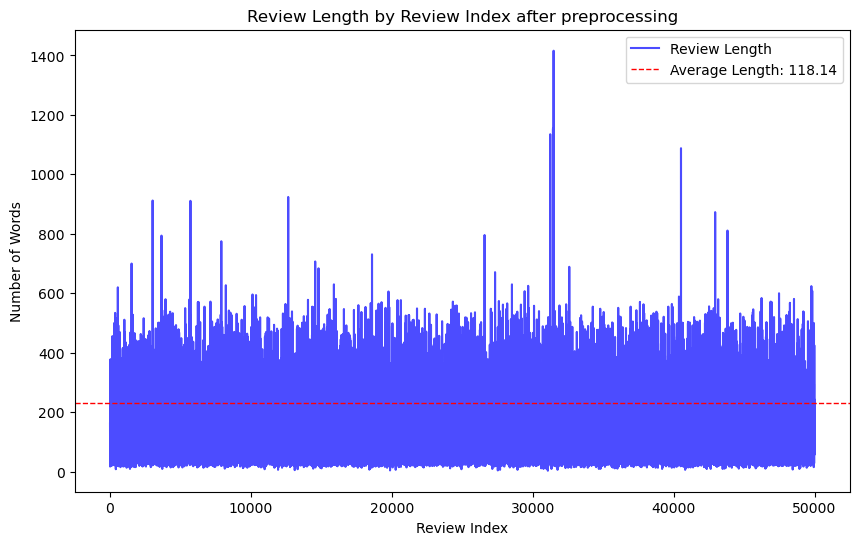

In [15]:
# Calculate word count for each preprocessed review
df['cleaned_word_count'] = df['cleaned_reviews'].apply(lambda x: len(x.split()))

# Calculate the average review length
average_tokens_length = df['cleaned_word_count'].mean()
print(f"Average Review Length after preprocessing: {average_tokens_length}")

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['cleaned_word_count'], color='blue', alpha=0.7, label='Review Length')
plt.axhline(average_review_length, color='red', linestyle='dashed', linewidth=1, label=f'Average Length: {average_tokens_length:.2f}')
plt.title('Review Length by Review Index after preprocessing')
plt.xlabel('Review Index')
plt.ylabel('Number of Words')
plt.legend()
plt.show()

In [16]:
per = ((average_review_length - average_tokens_length) / average_review_length) * 100
print(f"Percentage of Word Count Reduced: {per:.2f}%")

Percentage of Word Count Reduced: 48.89%


## Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

X = df['cleaned_reviews']
y = df['sentiment']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Print their sizes 
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 40000
Testing set size: 10000


## Feature Extraction

#### Bag of Words

In [19]:
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

In [20]:
print(X_train_bow)

  (0, 29977)	1
  (0, 3062)	1
  (0, 34336)	3
  (0, 19426)	1
  (0, 49400)	1
  (0, 34889)	1
  (0, 54994)	1
  (0, 21723)	1
  (0, 35070)	1
  (0, 42292)	1
  (0, 36515)	1
  (0, 11280)	1
  (0, 1482)	1
  (0, 53280)	2
  (0, 56574)	1
  (0, 40281)	4
  (0, 14808)	1
  (0, 9521)	1
  (0, 32703)	1
  (0, 14243)	1
  (0, 61089)	1
  (0, 27031)	1
  (0, 8663)	1
  (0, 24279)	1
  (0, 3913)	1
  :	:
  (39999, 45969)	1
  (39999, 417)	3
  (39999, 45010)	1
  (39999, 9347)	1
  (39999, 57649)	1
  (39999, 27229)	1
  (39999, 13713)	1
  (39999, 7621)	1
  (39999, 28913)	1
  (39999, 41167)	1
  (39999, 14473)	1
  (39999, 56747)	1
  (39999, 25340)	1
  (39999, 20491)	1
  (39999, 27693)	1
  (39999, 18762)	1
  (39999, 44155)	1
  (39999, 48773)	1
  (39999, 18370)	1
  (39999, 9672)	1
  (39999, 34962)	1
  (39999, 56075)	1
  (39999, 23302)	1
  (39999, 14792)	1
  (39999, 11253)	1


#### TF-IDF Transformation

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [22]:
print(X_train_tfidf)

  (0, 24320)	0.08650250759285735
  (0, 57923)	0.03544648506755522
  (0, 5648)	0.08559362639532561
  (0, 48843)	0.050942366032854285
  (0, 60025)	0.07374614458102238
  (0, 44752)	0.07430202035777127
  (0, 15252)	0.10325148357927369
  (0, 36285)	0.07956329163039244
  (0, 436)	0.05309853368387277
  (0, 44378)	0.06401113462104666
  (0, 18643)	0.07371592842128225
  (0, 39203)	0.08596486512605814
  (0, 15973)	0.06485651421761043
  (0, 62674)	0.07212412674653693
  (0, 27294)	0.06999725340776679
  (0, 13625)	0.04990754857110798
  (0, 1472)	0.053982427253118324
  (0, 43237)	0.03434716484682804
  (0, 60156)	0.04311834077693947
  (0, 22252)	0.035816066054289164
  (0, 438)	0.038225827081036
  (0, 28162)	0.06205450406331703
  (0, 8008)	0.08282481752445611
  (0, 26089)	0.06338240749258044
  (0, 55300)	0.08825839914633914
  :	:
  (39999, 14912)	0.07866821880942426
  (39999, 18094)	0.05336505803769751
  (39999, 34060)	0.049781485981587804
  (39999, 34000)	0.09081205246197409
  (39999, 23109)	0.1824004

#### (row index, col index) value = sparse matrix in Coordinate list format .
#### col index = index in vocabulary created according to the feature extraction.
#### BOW considers only the count of word occurances in data for values where as Tf-idf will weigh words by their importance, hence unique words will have higher weight and common words will be weighed lower.

#### Shape of the matrices

In [23]:
print(f"Bag of Words - Training set shape: {X_train_bow.shape}")
print(f"Bag of Words - Testing set shape: {X_test_bow.shape}")
print(f"TF-IDF - Training set shape: {X_train_tfidf.shape}")
print(f"TF-IDF - Testing set shape: {X_test_tfidf.shape}")

Bag of Words - Training set shape: (40000, 64400)
Bag of Words - Testing set shape: (10000, 64400)
TF-IDF - Training set shape: (40000, 64400)
TF-IDF - Testing set shape: (10000, 64400)


## Model - Logistic Regression

#### Bag of Words

In [24]:
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
y_pred_bow_lr = lr_bow.predict(X_test_bow)
print(y_pred_bow_lr)

[0 1 0 ... 1 0 1]


/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### TF-IDF

In [25]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_lr = lr_tfidf.predict(X_test_tfidf)
print(y_pred_tfidf_lr)

[0 1 0 ... 1 0 1]


## Model - Naive Bayes

#### Bag of words

In [26]:
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
y_pred_bow_nb = nb_bow.predict(X_test_bow)

#### TF-IDF

In [27]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)

## Evaluation

#### Bag of Words

##### Linear regression Model

In [28]:
accuracy_lr_bow = accuracy_score(y_test, y_pred_bow_lr)
print("Bag of Words - Accuracy: ",accuracy_lr_bow) 
print("Bag of Words - Classification Report:\n", classification_report(y_test, y_pred_bow_lr))

Bag of Words - Accuracy:  0.8796
Bag of Words - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



##### Naive Bayes

In [29]:
accuracy_nb_bow = accuracy_score(y_test, y_pred_bow_nb)
print(f"Accuracy of Naive Bayes with Bag of Words: {accuracy_nb_bow:.2f}")
print(classification_report(y_test, y_pred_bow_nb))

Accuracy of Naive Bayes with Bag of Words: 0.85
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4961
           1       0.87      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



#### TF-IDF

##### Linear Regression Model

In [30]:
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_tfidf_lr)
print("TF-IDF - Accuracy: ", accuracy_lr_tfidf)
print("TF-IDF - Classification Report:\n", classification_report(y_test, y_pred_tfidf_lr))

TF-IDF - Accuracy:  0.8922
TF-IDF - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



##### Naive Bayes 

In [31]:
accuracy_nb_tfidf = accuracy_score(y_test, y_pred_tfidf_nb)
print(f"Accuracy of Naive Bayes with TF-IDF: {accuracy_nb_tfidf:.2f}")
print(classification_report(y_test, y_pred_tfidf_nb))

Accuracy of Naive Bayes with TF-IDF: 0.86
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4961
           1       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Comparision

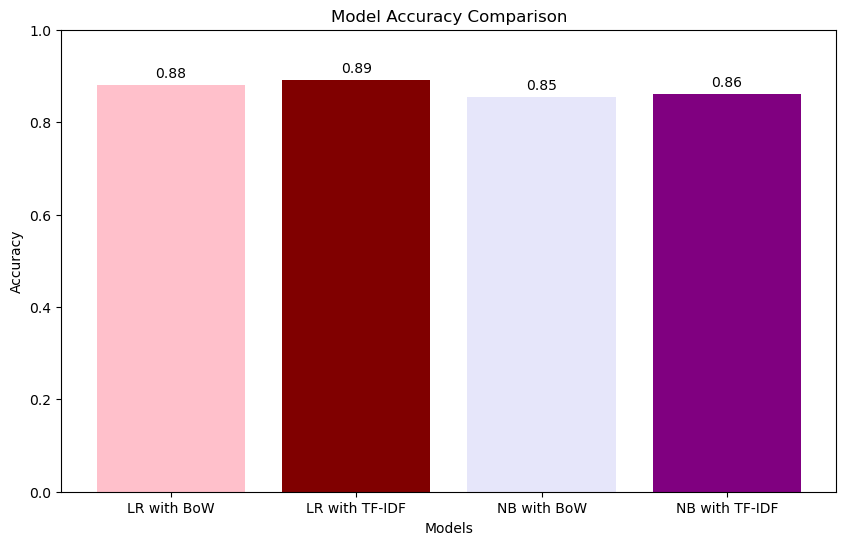

In [32]:
# Accuracy scores
accuracies = [accuracy_lr_bow, accuracy_lr_tfidf, accuracy_nb_bow, accuracy_nb_tfidf]
models = ['LR with BoW', 'LR with TF-IDF', 'NB with BoW', 'NB with TF-IDF']

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['pink', 'maroon', 'lavender', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()

/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/akshathaaavinashannadhani/anaconda3/lib/python3.11/site-packa

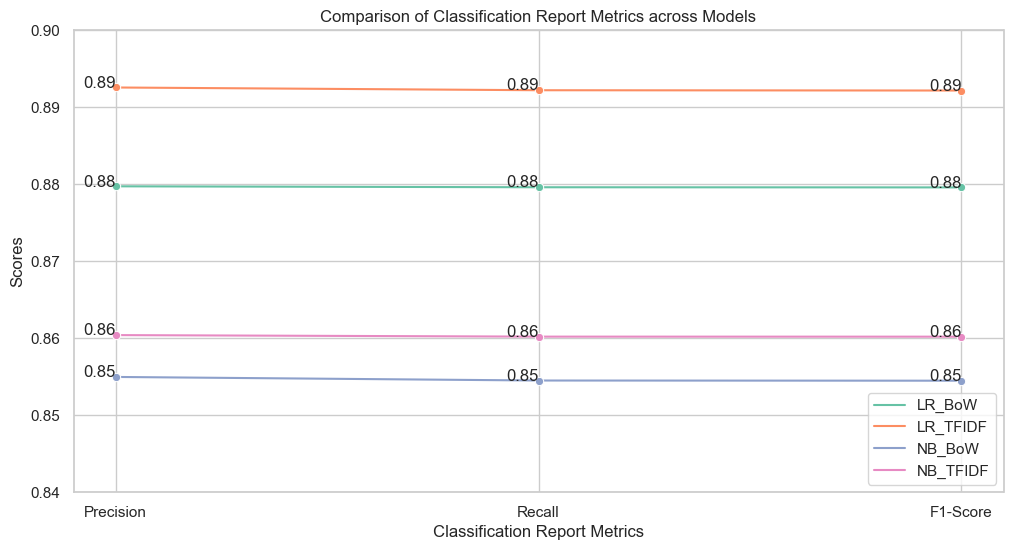

In [33]:
report_lr_bow = classification_report(y_test, y_pred_bow_lr, output_dict=True)
report_lr_tfidf = classification_report(y_test, y_pred_tfidf_lr, output_dict=True)
report_nb_bow = classification_report(y_test, y_pred_bow_nb, output_dict=True)
report_nb_tfidf = classification_report(y_test, y_pred_tfidf_nb, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']

# Create a DataFrame to hold all metrics 
data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'LR_BoW': [report_lr_bow['weighted avg']['precision'], report_lr_bow['weighted avg']['recall'], report_lr_bow['weighted avg']['f1-score']],
    'LR_TFIDF': [report_lr_tfidf['weighted avg']['precision'], report_lr_tfidf['weighted avg']['recall'], report_lr_tfidf['weighted avg']['f1-score']],
    'NB_BoW': [report_nb_bow['weighted avg']['precision'], report_nb_bow['weighted avg']['recall'], report_nb_bow['weighted avg']['f1-score']],
    'NB_TFIDF': [report_nb_tfidf['weighted avg']['precision'], report_nb_tfidf['weighted avg']['recall'], report_nb_tfidf['weighted avg']['f1-score']]
}

df_metrics = pd.DataFrame(data)


sns.set(style="whitegrid")
df_melted = df_metrics.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x='Metric', y='Score', hue='Model', marker='o', palette='Set2')
plt.xlabel('Classification Report Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Classification Report Metrics across Models')
plt.ylim(0.84, 0.9)
for line in plt.gca().lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        plt.text(x_value, y_value, f"{y_value:.2f}", ha='right')
plt.legend(loc='lower right')
plt.show()


#### Weighted average is the best one to look into as it is more reflective about the model's performance accross all the classes

### Observation

#### Overall best feature extraction menthod is Tf-idf as it considers important words, reducing the the impact of common words and hence more accuracy

#### best model for training is Linear Regression method since both variants of using Bag of words and Tfidf show high precission and accuracy scores

#### model with the best accuracy, high precision, recall and f1 score proves to be the best one hence Linear Regression with Tf-idf is the best one amongst all the other variants.

### Confusion Matrix

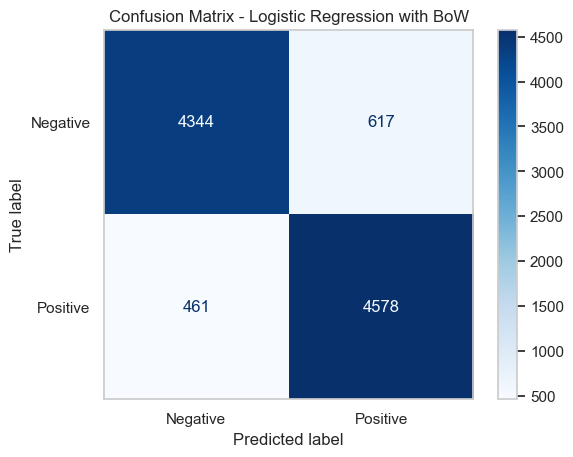

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_tfidf_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title('Confusion Matrix - Logistic Regression with BoW')
plt.show()

#### this is the best classification results provided by the model.

## Saving the models

In [35]:
import joblib
joblib.dump(lr_bow, 'lr_bow_model.pkl') #linear regression models
joblib.dump(lr_tfidf, 'lr_tfidf_model.pkl')
joblib.dump(nb_bow, 'nb_bow_model.pkl') # naive bayes models
joblib.dump(nb_tfidf, 'nb_tfidf_model.pkl')

# save the vectorizers
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("Models and vectorizers saved successfully.")

Models and vectorizers saved successfully.


## Access the model

#### load the saved model

In [36]:
# load the models
lr_bow_loaded = joblib.load('lr_bow_model.pkl')
lr_tfidf_loaded = joblib.load('lr_tfidf_model.pkl')
loaded_nb_bow = joblib.load('nb_bow_model.pkl')
loaded_nb_tfidf = joblib.load('nb_tfidf_model.pkl')

# Load the vectorizers
count_vectorizer_loaded = joblib.load('count_vectorizer.pkl')
tfidf_vectorizer_loaded = joblib.load('tfidf_vectorizer.pkl')

print("Models and vectorizers loaded successfully.")

Models and vectorizers loaded successfully.


#### Example

In [37]:

example_review = "OMG THIS MOVIE ROCKS! I SEEN IT 14 TIMES!."

# Preprocess 
processed_review = review_to_words(example_review)

# vectorize 
bow_review = count_vectorizer_loaded.transform([processed_review])
tfidf_review = tfidf_vectorizer_loaded.transform([processed_review])

# Make predictions 
prediction_bow = lr_bow_loaded.predict(bow_review)
prediction_tfidf = lr_tfidf_loaded.predict(tfidf_review)
pred_bow = loaded_nb_bow.predict(bow_review)
pred_tfidf = loaded_nb_tfidf.predict(tfidf_review)

# results
print(f"Review: '{example_review}'")
print("Linear Regression Model: ")
if prediction_bow[0]==1:
    print(f"Predicted sentiment using BoW model: positive")
else:
    print(f"Predicted sentiment using BoW model: negative")

if prediction_tfidf[0]==1:
    print(f"Predicted sentiment using Tfidf model: positive")
else:
    print(f"Predicted sentiment using Tfidf model: negative")
print("Naive Bayes Model: ")
if pred_bow[0]==1:
    print(f"Predicted sentiment using BoW model: positive")
else:
    print(f"Predicted sentiment using BoW model: negative")
if pred_tfidf[0]==1:
    print(f"Predicted sentiment using Tfidf model: positive")
else:
    print(f"Predicted sentiment using Tfidf model: negative")

Review: 'OMG THIS MOVIE ROCKS! I SEEN IT 14 TIMES!.'
Linear Regression Model: 
Predicted sentiment using BoW model: positive
Predicted sentiment using Tfidf model: positive
Naive Bayes Model: 
Predicted sentiment using BoW model: negative
Predicted sentiment using Tfidf model: negative
